# Analyzing the internal state, while changing the input

To measure the similarity of segments, we use the result of previous work [44] showing that in state-of- the art convolutional neural networks (CNNs) trained on large-scale data sets like ImageNet [32], the euclidean distance in the activation space of final layers is an effective perceptual similarity metric.

The experiment checks how similar board positions are by analyzing the activations space

 - Smallest sufficient concepts (SSC) which looks for the smallest set of concepts that are enough for predicting the target class. 
 - Smallest destroying concepts (SDC) which looks for the smallest set of concepts removing which will cause incorrect prediction.

In [1]:
from utils import *

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [66]:
model.eval()
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.prediction.res_blocks.register_forward_hook(get_activation('res_blocks'))

In [149]:
grid = np.array([[2, 0, 0, 2, 0],
                [2, 0, 2, 2, 2],
                [0, 2, 0, 1, 0],
                [0, 1, 1, 0, 0],
                [0, 1, 1, 1, 0],
                [1, 1, 1, 1, 1]])
player_to_move = 1

In [162]:
def distance_measure(m1, m2, distance = 'cos'):
    if distance == 'cos':
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        m = 1 - cos(torch.unsqueeze(torch.flatten(act_orig),0),torch.stack(mats)).cpu().numpy()
    elif distance == 'cdist':
        m = torch.cdist(torch.unsqueeze(torch.flatten(act_orig),0), torch.stack(mats), p=2.0).cpu().numpy()[0]
    return m

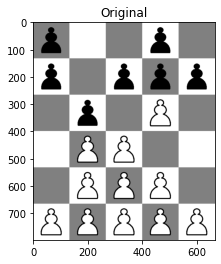

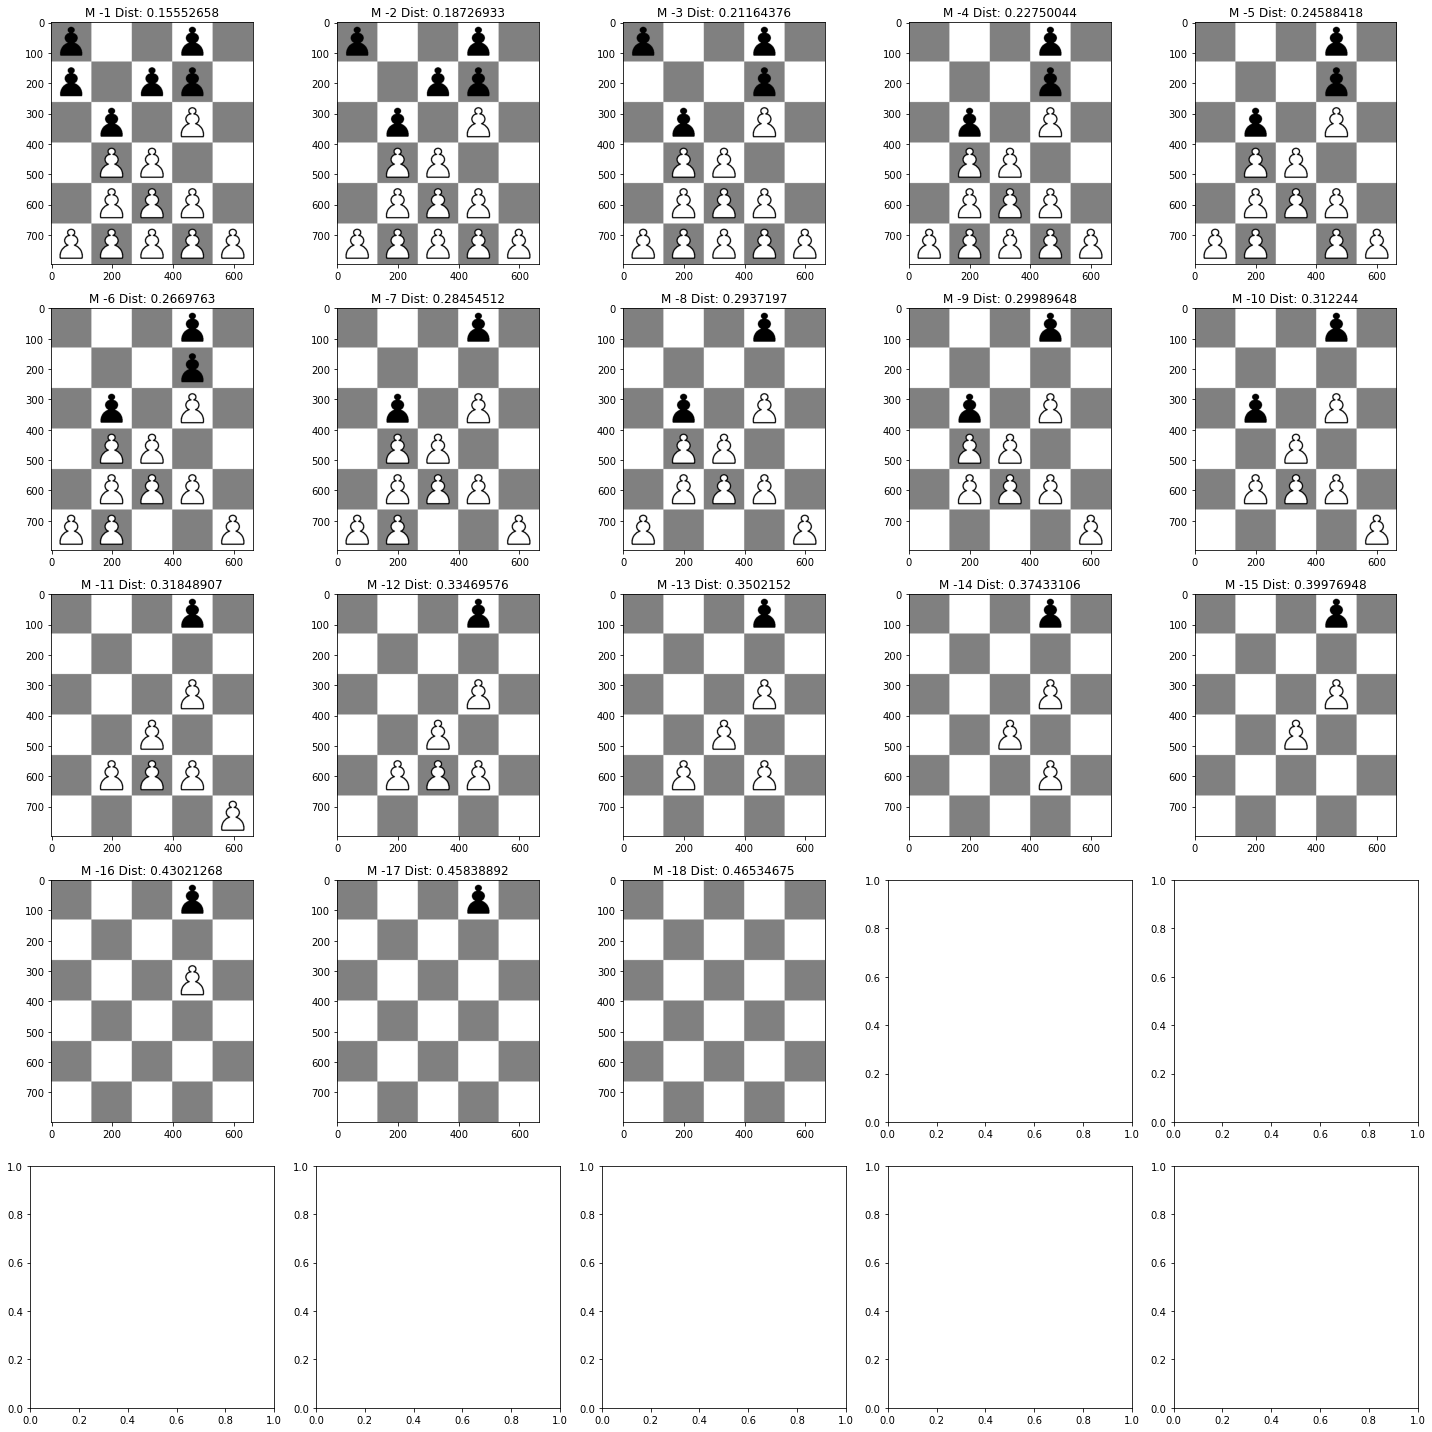

In [167]:
board = Board(5, grid)
state = State(board=board, player_to_move = player_to_move)
state_inter = copy.deepcopy(state)
x = state_inter.feature()
output = model.prediction.inference(x)
act_inter = activation['res_blocks']
plt.imshow(get_image_array(state))
plt.title('Original')
plt.show()

COMPARE_TO_ORIGINAL = True
distance = 'cos'

total_num = np.sum(state.board.grid != 0)
grid_size = int(np.ceil(np.sqrt(total_num)))

fig, axs = plt.subplots(grid_size, grid_size, figsize = (20,20))

for num in range(total_num):
    pieces_pos = np.where(state_inter.board.grid != 0)
    mats = []
    for idx, (x,y) in enumerate(zip(pieces_pos[0],pieces_pos[1])):
        state_ = copy.deepcopy(state_inter)
        state_.board.grid[x,y] = 0
        x = state_.feature()
        output = model.prediction.inference(x)
        act = activation['res_blocks']

        mats.append(torch.flatten(act))
        
        
    m = distance_measure(act_inter, mats, distance = distance)
        
    max_sim = np.argmin(m)
    
    throw_idx = (pieces_pos[0][max_sim], pieces_pos[1][max_sim])    
    state_inter.board.grid[throw_idx[0], throw_idx[1]] = 0
    
    if not COMPARE_TO_ORIGINAL:
        x = state_inter.feature()
        output = model.prediction.inference(x)
        act_inter = activation['res_blocks']
    
    axs[num // grid_size, num % grid_size].imshow(get_image_array(state_inter))
    axs[num // grid_size, num % grid_size].title.set_text('M -'+str(num+1)+ ' Dist: '+str(m[max_sim]))
plt.tight_layout()
plt.show()